# Getting Started with MLX on Apple Silicon

Welcome to this beginner-friendly guide to [MLX](https://github.com/ml-explore/mlx), an array framework for machine learning on Apple silicon.

In this notebook, we will:
1.  Cover basic operations (Array creation, Arithmetic).
2.  **Benchmark MLX vs. NumPy** to see the performance gains on your Mac's GPU.

In [1]:
import mlx.core as mx
import numpy as np
import matplotlib.pyplot as plt
import time

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. The Basics

MLX looks and feels a lot like NumPy. If you know NumPy, you know MLX!

In [2]:
# Creating Arrays
print("--- Creating Arrays ---")
scalar = mx.array(10)
vector = mx.array([1, 2, 3, 4, 5])
matrix = mx.array([[1, 2, 3], [4, 5, 6]])

print(f"Scalar: {scalar}")
print(f"Vector: {vector}")
print(f"Matrix:\n{matrix}")
print(f"Matrix Shape: {matrix.shape}")

--- Creating Arrays ---
Scalar: 10
Vector: array([1, 2, 3, 4, 5], dtype=int32)
Matrix:
array([[1, 2, 3],
       [4, 5, 6]], dtype=int32)
Matrix Shape: (2, 3)


In [3]:
# Arithmetic Operations
print("--- Arithmetic ---")
a = mx.array([10., 20., 30.])
b = mx.array([1., 2., 3.])

print(f"Addition: {a + b}")
print(f"Multiplication: {a * b}")
print(f"Dot Product: {a @ b}")

--- Arithmetic ---
Addition: array([11, 22, 33], dtype=float32)
Multiplication: array([10, 40, 90], dtype=float32)
Dot Product: 140.0


## 2. Performance Benchmark: MLX vs. NumPy

MLX is designed to take advantage of the unified memory and GPU on Apple Silicon. Let's demonstrate this with Matrix Multiplication.

We will multiply two square matrices of increasing sizes and compare the execution time.

In [4]:
def benchmark_matmul(size):
    # Create random matrices
    # NumPy
    np_a = np.random.rand(size, size).astype(np.float32)
    np_b = np.random.rand(size, size).astype(np.float32)
    
    # MLX
    mx_a = mx.random.uniform(shape=(size, size))
    mx_b = mx.random.uniform(shape=(size, size))
    mx.eval(mx_a, mx_b) # Ensure creation is done before timing

    # Time NumPy
    start_np = time.time()
    np_res = np_a @ np_b
    end_np = time.time()
    time_np = end_np - start_np

    # Time MLX
    # Note: MLX is lazy, so we must call execute() or eval() to force computation for timing
    start_mx = time.time()
    mx_res = mx_a @ mx_b
    mx.eval(mx_res)
    end_mx = time.time()
    time_mx = end_mx - start_mx

    return time_np, time_mx

print("Benchmark function defined.")

Benchmark function defined.


In [5]:
# Run Benchmark
sizes = [exp for exp in range(7, 14)] # Limited to 2^13 to avoid crashing
times_np = []
times_mx = []

print(f"Running benchmark for sizes: {sizes}...")
print("{:<10} | {:<15} | {:<15} | {:<10}".format("Size", "NumPy (s)", "MLX (s)", "Speedup"))
print("-"*60)

for size in sizes:
    t_np, t_mx = benchmark_matmul(2**size)
    times_np.append(t_np)
    times_mx.append(t_mx)
    speedup = t_np / t_mx
    print("{:<10} | {:<15.4f} | {:<15.4f} | {:<10.2f}x".format(size, t_np, t_mx, speedup))


Running benchmark for sizes: [7, 8, 9, 10, 11, 12, 13]...
Size       | NumPy (s)       | MLX (s)         | Speedup   
------------------------------------------------------------
7          | 0.0000          | 0.0018          | 0.03      x
8          | 0.0001          | 0.0004          | 0.18      x
9          | 0.0006          | 0.0006          | 1.05      x
10         | 0.0017          | 0.0025          | 0.69      x
11         | 0.0125          | 0.0158          | 0.79      x
12         | 0.0946          | 0.0542          | 1.75      x
13         | 0.7351          | 0.3485          | 2.11      x


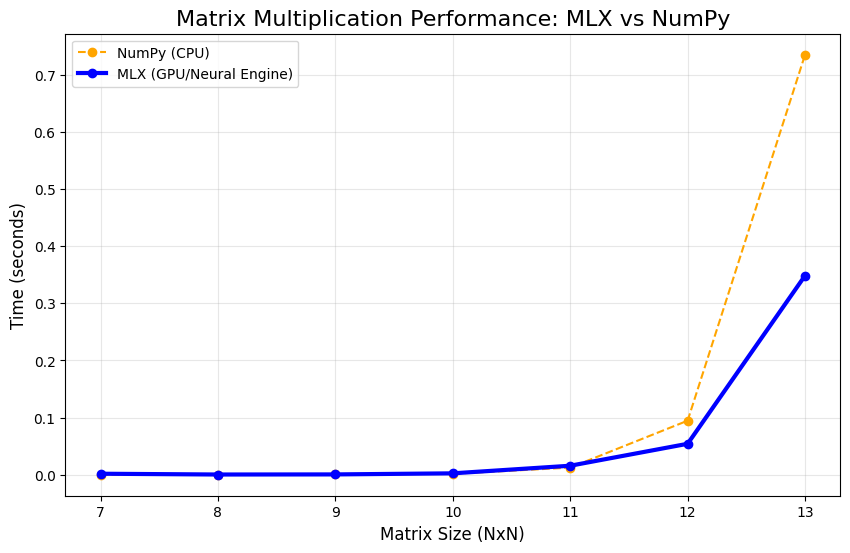

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_np, marker='o', label='NumPy (CPU)', linestyle='--', color='orange')
plt.plot(sizes, times_mx, marker='o', label='MLX (GPU/Neural Engine)', linewidth=3, color='blue')

plt.title('Matrix Multiplication Performance: MLX vs NumPy', fontsize=16)
plt.xlabel('Matrix Size (NxN)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

As you can see, as the matrix size increases, **MLX significantly outperforms NumPy** by leveraging the parallel processing power of the Apple Silicon GPU!

## 3. Large Scale Parallel Tasks: Batched Matrix Multiplication

The previous example crashed at huge sizes (like 32k x 32k) because a single matrix that large requires more memory than available.

However, in real-world Deep Learning, we often process **batches** of data in parallel. MLX shines here by running thousands of independent matrix multiplications simultaneously without the overhead of naive loops.

Let's simulate **thousands of parallel tasks** (batches). To ensure we validate compute performance (and not just run out of RAM), we'll use 256x256 matrices.

In [7]:
def benchmark_batched_matmul(batch_size, N=256):
    # NumPy: Using naive stacking
    np_a = np.random.rand(batch_size, N, N).astype(np.float32)
    np_b = np.random.rand(batch_size, N, N).astype(np.float32)

    # MLX
    mx_a = mx.random.uniform(shape=(batch_size, N, N))
    mx_b = mx.random.uniform(shape=(batch_size, N, N))
    mx.eval(mx_a, mx_b)

    # Warmup MLX (Trigger JIT Compilation)
    # The first run compiles the operation, subsequent runs are fast.
    warm_res = mx.matmul(mx_a, mx_b)
    mx.eval(warm_res)

    # Time NumPy
    start_np = time.time()
    np_res = np.matmul(np_a, np_b)
    end_np = time.time()
    time_np = end_np - start_np

    # Time MLX
    start_mx = time.time()
    mx_res = mx.matmul(mx_a, mx_b)
    mx.eval(mx_res)
    end_mx = time.time()
    time_mx = end_mx - start_mx

    return time_np, time_mx

# Run Batched Benchmark
batches = [10, 100, 500, 1000, 2000, 4000]
b_times_np = []
b_times_mx = []

print(f"Running BATCHED benchmark for N=256...\n")
print("{:<10} | {:<15} | {:<15} | {:<10}".format("Batch Size", "NumPy (s)", "MLX (s)", "Speedup"))
print("-"*60)

for b in batches:
    t_np, t_mx = benchmark_batched_matmul(b)
    b_times_np.append(t_np)
    b_times_mx.append(t_mx)
    speedup = t_np / t_mx
    print("{:<10} | {:<15.4f} | {:<15.4f} | {:<10.2f}x".format(b, t_np, t_mx, speedup))


Running BATCHED benchmark for N=256...

Batch Size | NumPy (s)       | MLX (s)         | Speedup   
------------------------------------------------------------
10         | 0.0005          | 0.0006          | 0.83      x
100        | 0.0067          | 0.0038          | 1.75      x
500        | 0.0334          | 0.0136          | 2.46      x
1000       | 0.0446          | 0.1919          | 0.23      x
2000       | 0.4458          | 0.2196          | 2.03      x
4000       | 0.9046          | 0.3145          | 2.88      x


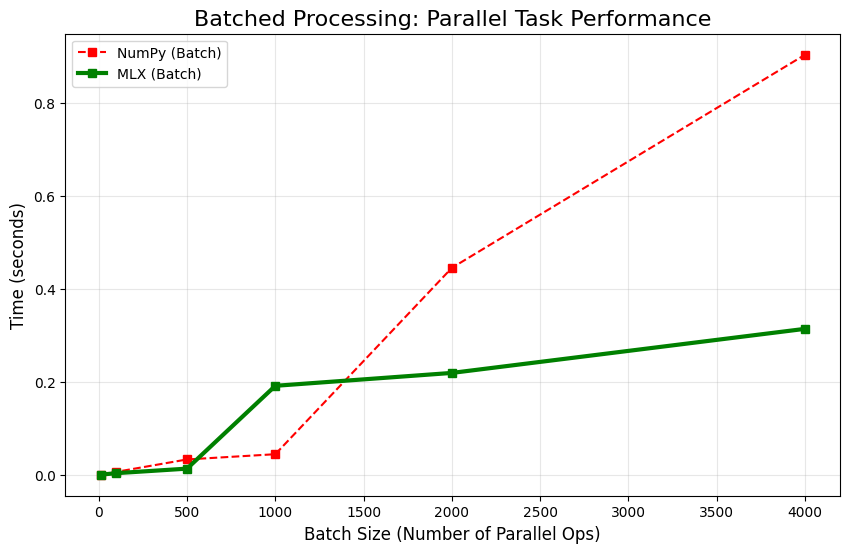

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(batches, b_times_np, marker='s', label='NumPy (Batch)', linestyle='--', color='red')
plt.plot(batches, b_times_mx, marker='s', label='MLX (Batch)', linewidth=3, color='green')

plt.title('Batched Processing: Parallel Task Performance', fontsize=16)
plt.xlabel('Batch Size (Number of Parallel Ops)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**Note on RAM:** If you increase the batch size or matrix size too much, your system will run out of Unified Memory/RAM, causing swapping which drastically kills performance. We use 256x256 here to stay safely within the GPU high-performance zone on most Macs.